<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install joblib
import tensorflow as tf 
import pickle
#from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


In [148]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## 64 BIT (2253,4016)
'''
with open('/content/drive/My Drive/ffeatures64.bin','rb') as file:
  features = pickle.load(file)
with open('/content/drive/My Drive/flabels64.bin','rb') as file:
  labels = pickle.load(file)
'''

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 56 BIT (2253,3147)
'''
features = joblib.load('/content/features56.pkl')
labels = joblib.load('/content/labels56.pkl')
'''

In [0]:
## 64 BIT (2253,3147)

features = joblib.load('/content/features64.pkl')
labels = joblib.load('/content/labels64.pkl')


In [0]:
## 32 BIT (2253,1035)
'''
features = joblib.load('/content/features32.pkl')
labels = joblib.load('/content/labels32.pkl') '''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''

In [234]:
# print(features[0])
# print(len(features[0]))
# print(len(features))
print(np.shape(features))

(2253, 4107)


In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [237]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12536811102307483961
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17810288432800085712
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2615115078038558223
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2963156849817122560
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
x = tf.placeholder(shape = (None,4107), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((4107, 500)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,500)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((500,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


                

In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [0]:
outl = tf.add(tf.matmul(hidl,wo),bo,name = 'output')

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.3*tf.reduce_max(tf.subtract(y,outl))
#default lr = 0.001
opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

In [255]:
train=[]
val=[]
with tf.device('/device:CPU:0'):
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,1000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
        
        ##TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      z= sess.run([loss,op_train], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      ##VALIDATION LOSS
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    
    simple_save(sess,'/content/drive/My Drive/Custom_Models/model1000_64',inputs = {'input' : x}, outputs = {'output': outl})
    print('Saved model!')
    

3250.8914	783.183
811.1821	2370.726
2448.3862	1431.3429
1042.9054	768.6296
727.15533	555.751
574.5222	1959.6338
682.99084	698.1384
920.9699	1046.3267
1619.5487	349.49908
760.6586	572.07336
783.58075	1569.0413
1449.9813	1689.1837
1130.9474	1037.4562
750.6218	636.26917
358.9157	143.93602
228.94293	924.271
228.98534	571.4269
1248.3589	1427.7715
1388.4406	304.70383
417.74448	934.2728
167.3552	430.95007
1046.4067	1370.3464
1018.504	568.0221
709.4876	1382.2043
1397.8027	1406.6224
832.1061	673.13293
339.4289	165.37436
860.1306	337.58395
674.79767	1464.9194
744.97327	657.6096
432.15863	1790.1451
814.10144	540.04626
236.45724	303.38977
1062.4308	330.24875
1408.5083	924.9616
823.92285	930.42944
651.15234	449.4421
1804.7178	1426.837
856.22784	955.2759
2077.8362	964.7768
1329.7744	195.60387
220.62468	710.30194
792.9477	283.43417
1148.6642	241.87378
605.7787	292.21402
576.64453	569.82635
1165.9875	466.33862
444.82892	558.5436
353.7253	1135.874
552.896	485.49677
354.25543	433.8775
1129.3918	481.0568

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_64.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

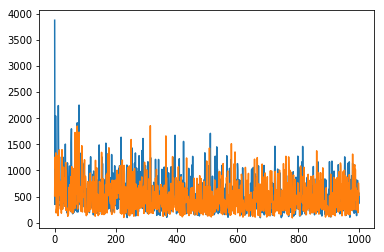

In [205]:
plt.plot(train)
plt.plot(val)

In [257]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(4107, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(500, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>]

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_updatedloss.pb', 'rb') as f:
  g1 = f.read()
with open('/content/drive/My Drive/Custom_Models/graph1000.pb', 'rb') as f:
  g2 = f.read()

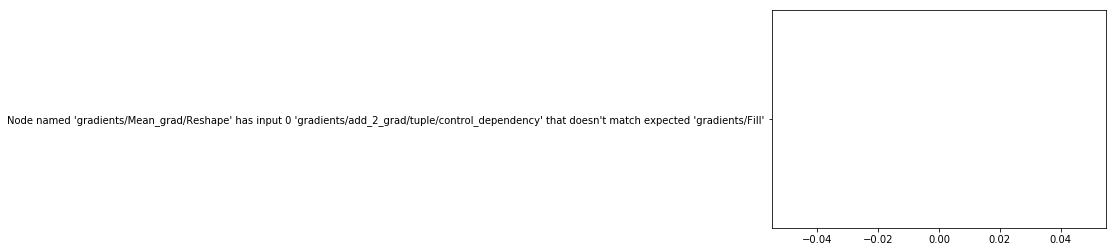

In [146]:
diff = pywrap_tensorflow.EqualGraphDefWrapper(g1,g2) 
#plt.plot(diff)